# Supplementary Figure 12, Activation marker flow cytometry under all combinations of treatments

In Supplementary Figure 12, we generate stacked horizontal bar plots showing the fraction of cells with activation marker expression as gated in FlowJo. Here, we'll generate plots for use in figure panels based on data stored in `06-flow-cytometry/data/`. 

The files involved in this analysis are not stored in HISE, so sources will be retrieved from within this git repository.

In [1]:
library(dplyr)
library(purrr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
out_dir <- "output/supp_figure_12"
dir.create(out_dir)

Warning message in dir.create(out_dir):
“'output/supp_figure_12' already exists”


## Read MFIs and helpers for plotting

In [3]:
res <- read.csv("../06-flow-cytometry/data/bor-len-dex_combin_CD69-CD40L_bin-counts.csv")

In [4]:
treat_order <- data.frame(
    treatment = c("DMSO","B","L","D","BL","DL","BD","BDL")
) %>%
  mutate(treat_order = factor(treatment, levels = treatment),
         treat_pos = c(1,2,2.5,3,4,4.5,5,6))

In [5]:
res <- res %>%
  group_by(subject, treatment, stim, population, feature) %>%
  mutate(frac = count / sum(count)) %>%
  mutate(cum_frac = cumsum(frac)) %>%
  ungroup()

Save modified results for supplements

In [6]:
out_res <- res %>%
  select(-cum_frac)

out_data <- paste0("combinatorial_activation_counts_", Sys.Date(), ".csv")

write.csv(
    out_res, 
    file.path(out_dir, out_data), 
    quote = FALSE, 
    row.names = FALSE
) 

## Generate stacked barplots

In [7]:
rect_ypos <- data.frame(
    feature = c(rep("CD69",6), rep("CD40L",6)),
    stim = c("no","no","no","yes","yes","yes","no","no","no","yes","yes","yes"),
    subject = rep(c("PB04863","PB04864","PB04865"),4),
    ypos = rev(c(1,2,3,4.5,5.5,6.5,9,10,11,12.5,13.5,14.5))
)
y_label_pos <- data.frame(
    ypos = c(2, 5.5, 10, 13.5),
    label = c("CD40L\nStim+", "CD40L\nStim-","CD69\nStim+","CD69\nStim-")
)

In [8]:
plot_data <- res %>%
  left_join(rect_ypos) %>%
  left_join(treat_order) %>%
  group_by(subject, treatment, stim, population, feature) %>%
  mutate(xmin = lag(cum_frac, default = 0),
         xmax = cum_frac) %>%
  ungroup() 

Joining with `by = join_by(subject, stim, feature)`
Joining with `by = join_by(treatment)`


In [9]:
dmso_marks <- plot_data %>%
  filter(treatment == "DMSO") %>%
  filter(xmin != 0) %>%
  select(population, ypos, xmin)

In [10]:
dmso_rects <- plot_data %>%
  filter(treatment == "DMSO") %>%
  select(-treat_order)

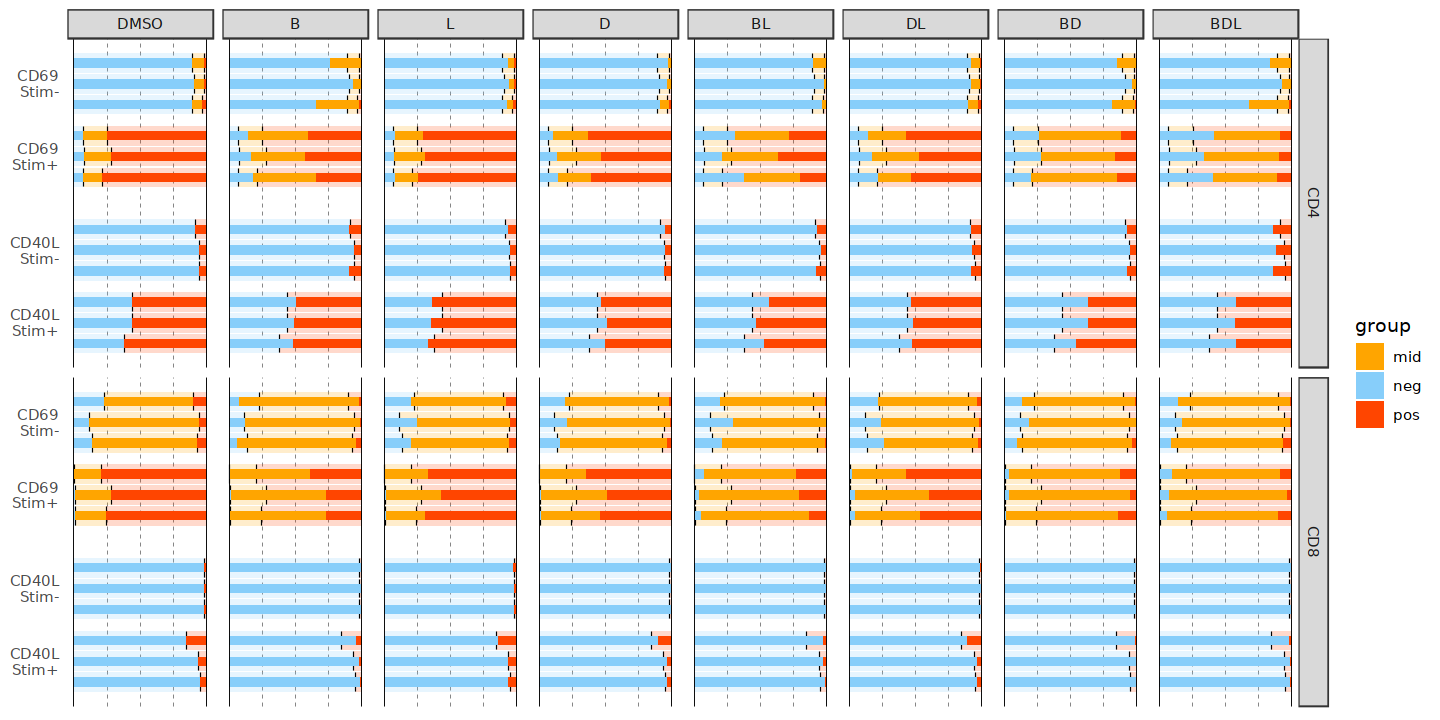

In [11]:
options(repr.plot.width = 12, repr.plot.height = 6)

p <- ggplot() +
  geom_vline(data = data.frame(x = c(0.25,0.5,0.75)),
             aes(xintercept = x),
             linetype = "dashed",
             linewidth = 0.2,
             color = "gray50") +
  geom_rect(
      data = dmso_rects,
      aes(ymin = ypos - 0.45, ymax = ypos + 0.45,
          xmin = xmin, xmax = xmax,
          fill = group),
      alpha = 0.2
  ) +
  geom_segment(
      data = dmso_marks,
      aes(x = xmin, xend = xmin,
          y = ypos - 0.45, yend = ypos + 0.45),
      linewidth = 0.25
  ) +

  geom_rect(
      data = plot_data,
      aes(ymin = ypos - 0.2, ymax = ypos + 0.2,
          xmin = xmin, xmax = xmax,
          fill = group)
  ) +
  geom_vline(data = data.frame(x = c(0,1)),
             aes(xintercept = x),
             linewidth = 0.2) +
  scale_y_continuous(
      breaks = y_label_pos$ypos,
      labels = y_label_pos$label
  ) +
  scale_fill_manual(
      breaks = c("mid","neg","pos"),
      values = c("orange","lightskyblue","orangered")
  ) +
  facet_grid(
      rows = vars(population),
      cols = vars(treat_order)
  ) +
  theme_bw() +
  theme(panel.border = element_blank(),
        panel.grid = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x = element_blank(),
        axis.title = element_blank())
p

In [12]:
out_file <- paste0("combinatorial_activation_barplots_", Sys.Date(), ".pdf")
ggsave(
    file.path(out_dir, out_file),
    p,
    width = 12, height = 6
)

In [13]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.3 purrr_1.0.2   dplyr_1.1.3  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     systemfonts_1.0.4 scales_1.2.1     
 [9] textshaping_0.3.6 uuid_1.1-1        fastmap_1.1.1     IRkernel_1